# Tutorial 9: Genetic Algorithm



## Prerequisites

- DEAP


## N Queen Problem

The N Queens Problem is the problem of placing eight queens on an N×N chessboard such that none of them attack one another (no two are in the same row, column, or diagonal). Below is one of the arrangements of an N=8 queen solution:

![](images/nqueen.png)

For this problem we assume each represent the coordinate of each queen on a vector.
The number on the element represents the row while the position on the vector represents the column. The coordinates for the picture above is given as:

<h1 align="center">[2, 4, 11, 13]</h1> 

### Utility function to draw chess board

Use `chess_board(queen_positions)` to draw the chess board.

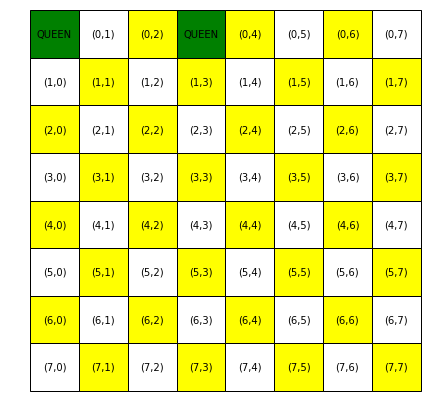

In [26]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.table import Table

%matplotlib inline


def chess_board_simple(queen_positions):

    # Make a 8x8 grid...
    nrows, ncols = 8,8
    image = np.zeros(nrows*ncols)

    # Set every other cell to a random number (this would be your data)
    for i, s in enumerate([0, 1, 0, 1, 0, 1, 0, 1]): 
        image.flat[np.arange(s+(i*8), (i+1)*8, 2)] = 1.

    image[queen_positions]=0.3
    # Reshape things into a 9x9 grid.
    image = image.reshape((nrows, ncols))

    row_labels = range(nrows)
    col_labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']

    plt.figure(figsize=(7, 7))
    plt.imshow(image, cmap='hot')
    plt.xticks(range(ncols), col_labels)
    plt.yticks(range(nrows), row_labels)

#draw_chess_board([1, 5, 45, 12, 34, 7, 21, 32])



def chess_board(queen_positions, bkg_colors=['yellow', 'white']):
    fig, ax = plt.subplots(figsize=(7,7))
    ax.set_axis_off()
    tb = Table(ax, bbox=[0,0,1,1])

    nrows, ncols = 8, 8
    width, height = 1.0 / ncols, 1.0 / nrows

    # Add cells
    for indx in range(64):
        i,j= np.unravel_index(indx, (8,8))
        # Index either the first or second item of bkg_colors based on
        # a checker board pattern
        idx = [j % 2, (j + 1) % 2][i % 2]
        color = bkg_colors[idx]

        if indx in queen_positions:
            tb.add_cell(i, j, width, height, text='QUEEN', 
                        loc='center', facecolor='green')
        else:
            tb.add_cell(i, j, width, height, text='({0},{1})'.format(i,j), 
                        loc='center', facecolor=color)

    ax.add_table(tb)
    return fig

_ = chess_board([0, 3])

### STEP 1: Import libraries

In [ ]:
import random

import numpy

from deap import algorithms
from deap import base
from deap import creator
from deap import tools

### STEP 2: Define fitness function

In [ ]:
#Problem parameter
NB_QUEENS = 8

def evalNQueens(individual):
    """Evaluation function for the n-queens problem.
    The problem is to determine a configuration of n queens
    on a nxn chessboard such that no queen can be taken by
    one another. In this version, each queens is assigned
    to one column, and only one queen can be on each line.
    The evaluation function therefore only counts the number
    of conflicts along the diagonals.
    """
    size = len(individual)
    #Count the number of conflicts with other queens.
    #The conflicts can only be diagonal, count on each diagonal line
    left_diagonal = [0] * (2*size-1)
    right_diagonal = [0] * (2*size-1)
    
    #Sum the number of queens on each diagonal:
    for i in range(size):
        left_diagonal[i+individual[i]] += 1
        right_diagonal[size-1-i+individual[i]] += 1
    
    #Count the number of conflicts on each diagonal
    sum_ = 0
    for i in range(2*size-1):
        if left_diagonal[i] > 1:
            sum_ += left_diagonal[i] - 1
        if right_diagonal[i] > 1:
            sum_ += right_diagonal[i] - 1
    return sum_,

### STEP 3: Create the evolution model
**Note:** We add `(-1.,)` because `DEAP` supports multi-objective optimization, however our case is just single objective function.


In [5]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

#Since there is only one queen per line, 
#individual are represented by a permutation
toolbox = base.Toolbox()
toolbox.register("permutation", random.sample, range(NB_QUEENS), NB_QUEENS)

#Structure initializers
#An individual is a list that represents the position of each queen.
#Only the line is stored, the column is the index of the number in the list.
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.permutation)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evalNQueens)
toolbox.register("mate", tools.cxPartialyMatched)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=2.0/NB_QUEENS)

toolbox.register("select", tools.selTournament, tournsize=3)

In [27]:
# Now we can create individuals and populations using toolbox

toolbox.individual()

[0, 5, 4, 1, 7, 3, 6, 2]

In [28]:
toolbox.population(n=10)

[[3, 6, 1, 2, 0, 5, 7, 4],
 [2, 7, 6, 3, 5, 4, 1, 0],
 [1, 4, 5, 0, 2, 7, 3, 6],
 [3, 2, 0, 6, 1, 7, 5, 4],
 [5, 1, 7, 4, 2, 6, 3, 0],
 [0, 3, 6, 1, 4, 7, 2, 5],
 [4, 3, 2, 6, 0, 5, 7, 1],
 [3, 2, 7, 0, 1, 4, 5, 6],
 [4, 2, 3, 0, 6, 7, 5, 1],
 [2, 3, 1, 6, 7, 4, 0, 5]]

### STEP 4: Create population and run the genetic algorithm

In [72]:
pop = toolbox.population(n=50)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("Avg", numpy.mean)
stats.register("Std", numpy.std)
stats.register("Min", numpy.min)
stats.register("Max", numpy.max)

pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=100, stats=stats,
                    halloffame=hof, verbose=True)

gen	nevals	Avg 	Std    	Min	Max
0  	50    	4.26	1.27765	1  	7  
1  	30    	3.56	1.1342 	1  	6  
2  	26    	3.08	1.01666	1  	5  
3  	28    	2.7 	1.00499	1  	5  
4  	30    	3.14	1.48337	1  	7  
5  	33    	2.44	1.26744	0  	6  
6  	34    	2.2 	1.11355	0  	5  
7  	28    	2.14	1.4968 	0  	6  
8  	33    	2.04	1.31088	0  	5  
9  	31    	2.26	1.65904	0  	7  
10 	28    	1.64	1.35292	0  	5  
11 	33    	1.34	1.27452	0  	5  
12 	24    	1.38	1.87499	0  	7  
13 	25    	1   	1.53623	0  	5  
14 	30    	1.04	1.58695	0  	5  
15 	27    	0.92	1.68333	0  	6  
16 	36    	0.64	1.35292	0  	5  
17 	33    	0.14	0.566039	0  	3  
18 	30    	0.56	1.20266 	0  	4  
19 	20    	0.38	1.07499 	0  	4  
20 	30    	0.22	0.900888	0  	5  
21 	32    	0.5 	1.18743 	0  	4  
22 	31    	0.76	1.50413 	0  	5  
23 	31    	0.62	1.21474 	0  	4  
24 	30    	0.7 	1.34536 	0  	5  
25 	29    	0.64	1.2126  	0  	4  
26 	29    	0.54	1.22    	0  	5  
27 	29    	0.66	1.24274 	0  	4  
28 	24    	0.5 	1.31529 	0  	5  
29 	34    	1.18	1.79655 	0  

## STEP 5: Winner individuals and Solution

Fitness Value: (0.0,)
Total solutions: 1


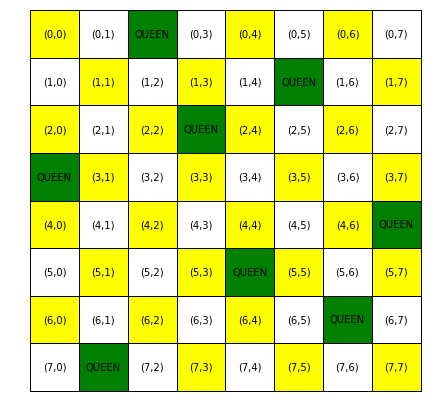

In [74]:
def convert_to_positions_on_board(ind):
    return map(lambda x: x[0]*8+x[1], enumerate(ind))
print 'Fitness Value: {0}'.format(hof[0].fitness)
_ = chess_board(convert_to_positions_on_board(hof[0]))

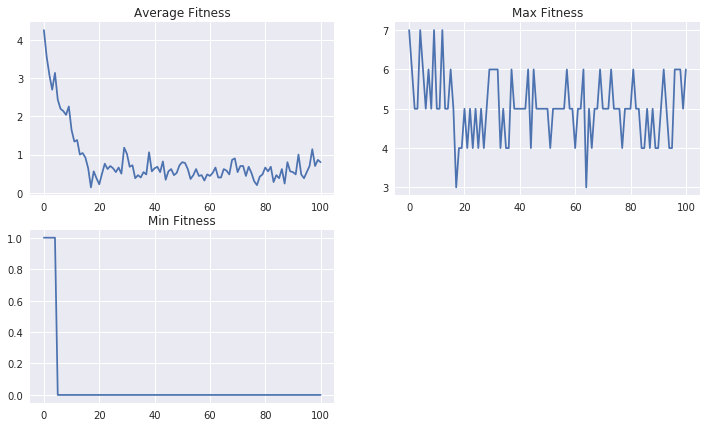

In [93]:
import seaborn

avg_fit = map(lambda x: x['Avg'], logbook)
min_fit = map(lambda x: x['Min'], logbook)
max_fit = map(lambda x: x['Max'], logbook)

plt.figure(figsize=(12, 7))
plt.subplot(2,2,1)
plt.plot(avg_fit)
plt.title('Average Fitness')
plt.subplot(2, 2, 2)
plt.plot(max_fit)
plt.title('Max Fitness')
plt.subplot(2, 2, 3)
plt.plot(min_fit)
plt.title('Min Fitness')